In [1]:
!pip install opendatasets --upgrade --quiet
!pip install kaggle --quiet

In [2]:
import opendatasets as od
import os
import random
import cv2
import numpy as np
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import LearningRateScheduler
from keras.optimizers import SGD
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from keras.models import Model
import tensorflow as tf
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score, classification_report
import time

In [3]:
dataset_url = 'https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset'
od.download(dataset_url)
data_dir = '/content/brain-tumors-dataset/Data'

def load_images_from_directory(directory):
    images, labels = [], []

    # Load images from the 'Normal' folder
    normal_path = os.path.join(directory, 'Normal')
    if os.path.isdir(normal_path):
        for file in os.listdir(normal_path):
            if file.endswith(".jpg"):

                image_path = os.path.join(normal_path, file)

                # Load and preprocess the image
                image = cv2.imread(image_path)
                if image is not None:
                    image = cv2.resize(image, (32, 32))
                    image = img_to_array(image)
                    images.append(image)

                    # Label as 'Normal'
                    labels.append('Normal')

    # Load images from subfolders in the 'Tumor' folder
    tumor_path = os.path.join(directory, 'Tumor')
    if os.path.isdir(tumor_path):
        for subdir in os.listdir(tumor_path):
            subdir_path = os.path.join(tumor_path, subdir)
            if os.path.isdir(subdir_path):
                for file in os.listdir(subdir_path):
                    if file.endswith(".jpg"):
                        image_path = os.path.join(subdir_path, file)

                        # Load and preprocess the image
                        image = cv2.imread(image_path)
                        if image is not None:
                            image = cv2.resize(image, (32, 32))
                            image = img_to_array(image)
                            images.append(image)

                            # Use the subfolder name as the label
                            labels.append(subdir)

    # Convert to numpy arrays and normalize the images
    return np.array(images, dtype="float") / 255.0, np.array(labels)

# Load all images and labels
images, labels = load_images_from_directory(data_dir)

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, stratify=labels, random_state=42)

# Binarize the labels
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)

# Check data loading and verify classes
print(f'Training samples: {len(x_train)}, Testing samples: {len(x_test)}')
print("Classes:", lb.classes_)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: harzh01
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/mohammadhossein77/brain-tumors-dataset


100%|██████████| 221M/221M [00:03<00:00, 63.4MB/s]



Training samples: 17337, Testing samples: 4335
Classes: ['Normal' 'glioma_tumor' 'meningioma_tumor' 'pituitary_tumor']


In [4]:
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    AveragePooling2D,
    Flatten,
    Dense,
    Dropout,
    BatchNormalization,
)
from tensorflow.keras.models import Model

def teacher_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Second block
    x = Conv2D(128, (5, 5), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Third block
    x = Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


def student_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # First block
    x = Conv2D(32, (5, 5), activation='relu', padding='same')(inputs)
    x = BatchNormalization()(x)
    x = MaxPooling2D((2, 2))(x)

    # Second block
    x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = BatchNormalization()(x)
    x = AveragePooling2D((2, 2))(x)

    # Fully connected layers
    x = Flatten()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.4)(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model


input_shape = (32, 32, 3)  # Updated input shape
num_classes = len(lb.classes_)


In [5]:
teacher = teacher_model(input_shape, num_classes)
student = student_model(input_shape, num_classes)

# Define a learning rate scheduler function
def lr_scheduler(epoch, lr):
    return float(lr * tf.math.exp(-0.1)) if epoch >= 10 else float(lr)

# Compile and train the teacher model
teacher.compile(optimizer=SGD(learning_rate=1e-2, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
teacher.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

# Precompute teacher's predictions for distillation
teacher_preds = teacher.predict(x_train)

Epoch 1/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 15s 15ms/step - accuracy: 0.5179 - loss: 1.2731 - val_accuracy: 0.6842 - val_loss: 0.7449 - learning_rate: 0.0100
Epoch 2/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 10s 5ms/step - accuracy: 0.7401 - loss: 0.6308 - val_accuracy: 0.7511 - val_loss: 0.6011 - learning_rate: 0.0100
Epoch 3/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - accuracy: 0.8420 - loss: 0.3965 - val_accuracy: 0.8247 - val_loss: 0.4578 - learning_rate: 0.0100
Epoch 4/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9114 - loss: 0.2345 - val_accuracy: 0.9089 - val_loss: 0.2394 - learning_rate: 0.0100
Epoch 5/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9372 - loss: 0.1705 - val_accuracy: 0.9386 - val_loss: 0.1769 - learning_rate: 0.0100
Epoch 6/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9564 - loss: 0.1101 - val_accuracy: 0.9218 - val_loss: 0.2304 - learning_rate: 0.0100
Epoch 7/8
542/542 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.9714 - loss: 0.0767 - val_

In [6]:


def distillation_loss(y_true, y_pred, teacher_preds, temperature=5.0, alpha=0.3):
    # Adjust temperature for teacher and student predictions
    teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
    y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
    teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

    # Compute KL divergence for soft loss
    soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)

    # Compute categorical cross-entropy for hard loss
    hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

    # Weighted combination of soft and hard losses
    return alpha * soft_loss + (1. - alpha) * hard_loss


In [7]:
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

Teacher test accuracy: 92.50%


In [8]:
student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds), metrics=['accuracy'])
student.fit(x_train, y_train, batch_size=32, epochs=15, validation_data=(x_test, y_test), callbacks=[LearningRateScheduler(lr_scheduler)])

Epoch 1/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 16s 20ms/step - accuracy: 0.6095 - loss: 0.7062 - val_accuracy: 0.6332 - val_loss: 0.7518 - learning_rate: 0.0010
Epoch 2/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8001 - loss: 0.3517 - val_accuracy: 0.8510 - val_loss: 0.2681 - learning_rate: 0.0010
Epoch 3/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.8801 - loss: 0.2176 - val_accuracy: 0.8551 - val_loss: 0.2610 - learning_rate: 0.0010
Epoch 4/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9200 - loss: 0.1534 - val_accuracy: 0.9140 - val_loss: 0.1664 - learning_rate: 0.0010
Epoch 5/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9418 - loss: 0.1098 - val_accuracy: 0.9241 - val_loss: 0.1626 - learning_rate: 0.0010
Epoch 6/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9529 - loss: 0.0869 - val_accuracy: 0.8999 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 7/15
542/542 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9642 - loss: 0.0721 

In [9]:
# Evaluate models
#teacher_score = teacher.evaluate(x_test, y_test, verbose=0)
student_score = student.evaluate(x_test, y_test, verbose=0)
#print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')
print(f'Student test accuracy: {student_score[1] * 100:.2f}%')

Student test accuracy: 94.49%


In [10]:
# Evaluate the teacher model
teacher_score = teacher.evaluate(x_test, y_test, verbose=0)

print(f'Teacher test accuracy: {teacher_score[1] * 100:.2f}%')

# Generate predictions from the teacher model
teacher_preds_probs = teacher.predict(x_test)
teacher_preds = np.argmax(teacher_preds_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

# Print the classification report for the teacher model
print("=== Teacher Model Classification Report ===")
print(classification_report(y_true, teacher_preds, target_names=lb.classes_))

Teacher test accuracy: 92.50%
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
=== Teacher Model Classification Report ===
                  precision    recall  f1-score   support

          Normal       0.96      0.95      0.95       613
    glioma_tumor       0.85      0.95      0.90      1262
meningioma_tumor       0.97      0.82      0.89      1278
 pituitary_tumor       0.96      0.99      0.98      1182

        accuracy                           0.93      4335
       macro avg       0.93      0.93      0.93      4335
    weighted avg       0.93      0.93      0.92      4335



In [11]:
alpha_values = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
temperature_values = [1.0, 2.0, 5.0, 10.0]  # Adjust temperature values as needed

results = []  # To store results for each combination of alpha and temperature

teacher_preds = teacher.predict(x_train)

# Function to evaluate F1-score, accuracy, precision, recall, and inference time for a given alpha and temperature
def evaluate_student(alpha, temperature):
    def distillation_loss(y_true, y_pred, teacher_preds, temperature=temperature, alpha=alpha):
        teacher_batch_preds = tf.gather(teacher_preds, tf.range(tf.shape(y_pred)[0]))
        y_pred_soft = tf.keras.activations.softmax(y_pred / temperature)
        teacher_batch_preds_soft = tf.keras.activations.softmax(teacher_batch_preds / temperature)

        soft_loss = tf.keras.losses.KLDivergence()(teacher_batch_preds_soft, y_pred_soft)
        hard_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)

        return alpha * soft_loss + (1. - alpha) * hard_loss

    student.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                    loss=lambda y_true, y_pred: distillation_loss(y_true, y_pred, teacher_preds),
                    metrics=['accuracy'])

    student.fit(x_train, y_train, batch_size=32, epochs=8, validation_data=(x_test, y_test),
                callbacks=[LearningRateScheduler(lr_scheduler)], verbose=0)

    start_time = time.time()
    y_pred_probs = student.predict(x_test)
    inference_time = time.time() - start_time
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    f1 = f1_score(y_true, y_pred, average='weighted')
    acc = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    # Store the results in the dictionary
    results.append({
        "alpha": alpha,
        "temperature": temperature,
        "f1_score": f1,
        "accuracy": acc,
        "precision": precision,
        "recall": recall,
        "inference_time": inference_time
    })

    print(f"=== Alpha: {alpha}, Temperature: {temperature} ===")
    print(f"F1 Score: {f1:.4f}, Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}")
    print(f"Inference Time: {inference_time:.4f} seconds\n")

# Run evaluation for each combination of alpha and temperature
for alpha in alpha_values:
    for temperature in temperature_values:
        evaluate_student(alpha, temperature)

542/542 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
=== Alpha: 0.0, Temperature: 1.0 ===
F1 Score: 0.9458, Accuracy: 0.9460, Precision: 0.9468, Recall: 0.9460
Inference Time: 1.4452 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
=== Alpha: 0.0, Temperature: 2.0 ===
F1 Score: 0.9276, Accuracy: 0.9278, Precision: 0.9291, Recall: 0.9278
Inference Time: 0.9673 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 0.0, Temperature: 5.0 ===
F1 Score: 0.9544, Accuracy: 0.9546, Precision: 0.9544, Recall: 0.9546
Inference Time: 1.4514 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 0.0, Temperature: 10.0 ===
F1 Score: 0.9507, Accuracy: 0.9509, Precision: 0.9508, Recall: 0.9509
Inference Time: 1.4505 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 0.1, Temperature: 1.0 ===
F1 Score: 0.9440, Accuracy: 0.9442, Precision: 0.9464, Recall: 0.9442
Inference Time: 0.9706 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
=== Alpha: 0.1, T

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Alpha: 1.0, Temperature: 1.0 ===
F1 Score: 0.1313, Accuracy: 0.2911, Precision: 0.0848, Recall: 0.2911
Inference Time: 1.4596 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 1.0, Temperature: 2.0 ===
F1 Score: 0.1313, Accuracy: 0.2911, Precision: 0.0848, Recall: 0.2911
Inference Time: 0.9687 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


=== Alpha: 1.0, Temperature: 5.0 ===
F1 Score: 0.1313, Accuracy: 0.2911, Precision: 0.0848, Recall: 0.2911
Inference Time: 1.4491 seconds

136/136 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
=== Alpha: 1.0, Temperature: 10.0 ===
F1 Score: 0.1313, Accuracy: 0.2911, Precision: 0.0848, Recall: 0.2911
Inference Time: 0.9655 seconds



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


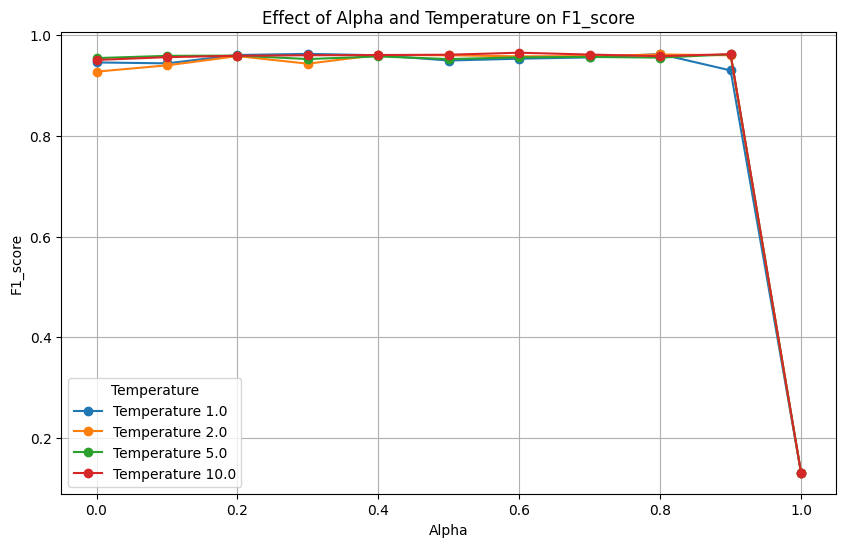

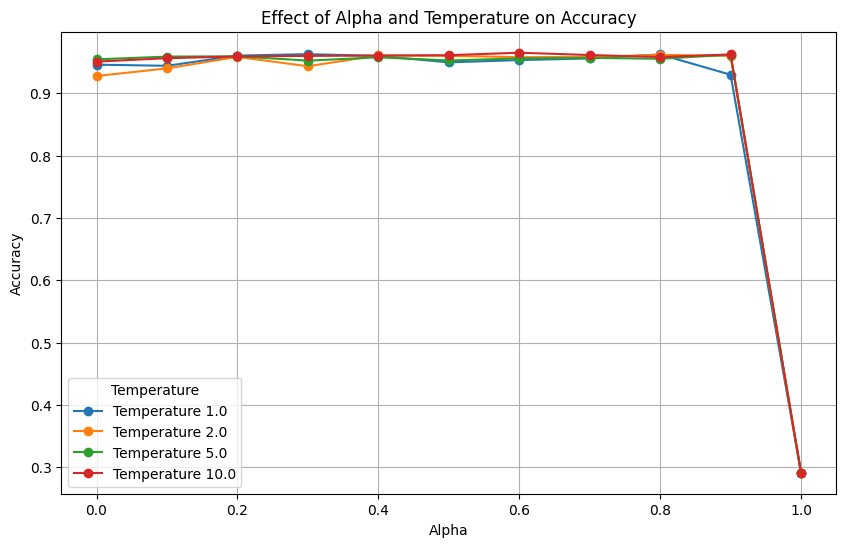

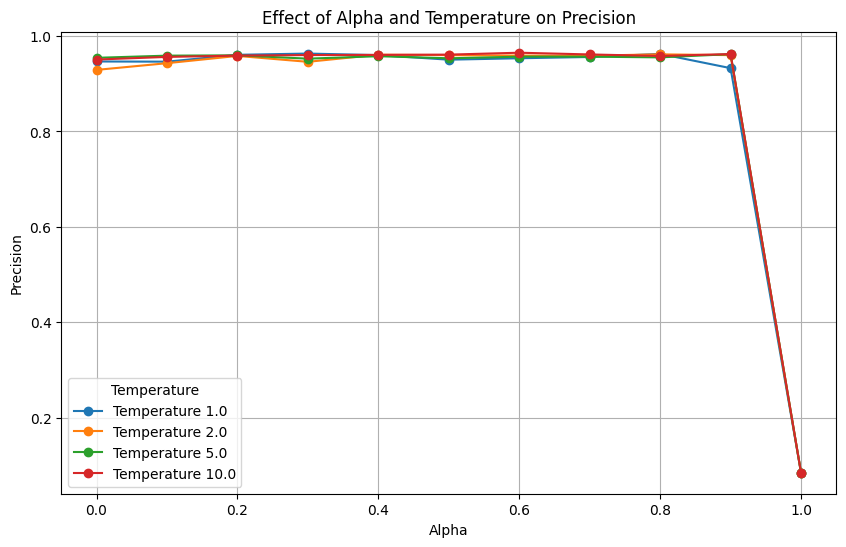

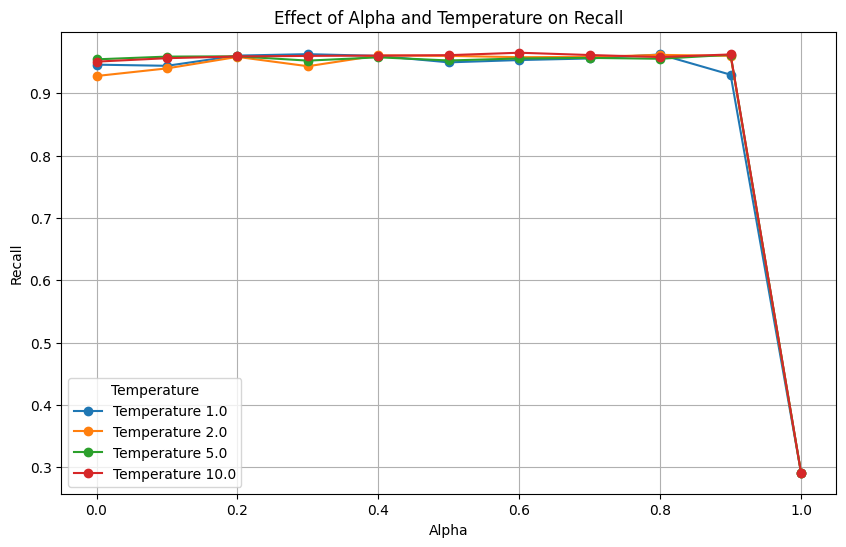

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

# Example results data (replace this with your actual results)
# results = [
#     {"alpha": 0.0, "temperature": 1.0, "f1_score": 0.75, "accuracy": 0.8, "precision": 0.78, "recall": 0.76, "inference_time": 0.05},
#     {"alpha": 0.1, "temperature": 1.0, "f1_score": 0.76, "accuracy": 0.81, "precision": 0.79, "recall": 0.77, "inference_time": 0.06},
#     ...
# ]

# Convert results to a DataFrame
results_df = pd.DataFrame(results)

# Create subplots for each metric
metrics = ['f1_score', 'accuracy', 'precision', 'recall']
for metric in metrics:
    plt.figure(figsize=(10, 6))
    for temp in results_df['temperature'].unique():
        subset = results_df[results_df['temperature'] == temp]
        plt.plot(subset['alpha'], subset[metric], marker='o', label=f'Temperature {temp}')

    plt.title(f'Effect of Alpha and Temperature on {metric.capitalize()}')
    plt.xlabel('Alpha')
    plt.ylabel(metric.capitalize())
    plt.legend(title="Temperature")
    plt.grid(True)
    plt.show()
